# Comprehensive Image Analysis Notebook

This notebook analyzes facial expressions, overall image mood, lighting conditions, and provides a more diverse range of mood categories.

In [4]:
# Install required packages
!pip install opencv-python-headless mtcnn tensorflow>=2.13 vaderSentiment scikit-learn --break-system-packages

In [1]:
# Import necessary libraries
import cv2
import numpy as np
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler

2024-09-08 01:08:56.768176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 01:08:56.794158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-08 01:08:56.837414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-08 01:08:56.921159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-08 01:08:56.940775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-08 01:08:56.980336: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Load the pre-trained MTCNN face detector
detector = MTCNN()

# Load your pre-trained expression analysis model
# Replace 'path/to/your/model.keras' with the actual path to your model
model = keras.models.load_model('r2_best_model.keras')

# Display model summary
model.summary()

# Get the input shape required by the model
input_shape = model.input_shape[1:]  # Exclude the batch dimension
print(f"Model input shape: {input_shape}")

# Initialize VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Initialize MinMaxScaler for normalizing features
scaler = MinMaxScaler()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 6,214,743 (23.71 MB)

 Trainable params: 1,318,919 (5.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,637,840 (10.06 MB)

Model input shape: (224, 224, 3)


In [3]:
# Define emotion labels (adjust these based on your model's output)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def detect_faces(image_path):
    # Read the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    result = detector.detect_faces(image_rgb)
    
    return image, result

def preprocess_face(face, target_shape):
    # Resize the face image to match the model's input size
    face = cv2.resize(face, (target_shape[1], target_shape[0]))
    
    # Convert to grayscale if the model expects single-channel input
    if target_shape[-1] == 1:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = np.expand_dims(face, axis=-1)
    elif face.shape[-1] == 1:  # If the face is grayscale but model expects color
        face = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)
    
    # Normalize pixel values
    face = face.astype("float32") / 255.0
    
    # Expand dimensions to create a batch of size 1
    face = np.expand_dims(face, axis=0)
    
    return face

def predict_emotion(face):
    # Make prediction
    preds = model.predict(face)[0]
    emotion = emotion_labels[np.argmax(preds)]
    return emotion, preds

def draw_faces_with_emotions(image, faces, emotions):
    for (x, y, w, h), emotion in zip(faces, emotions):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(image, emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    return image

def analyze_lighting(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate average brightness
    avg_brightness = np.mean(gray)
    
    # Calculate contrast
    contrast = np.std(gray)
    
    if avg_brightness < 64:
        lighting = "Dark"
    elif avg_brightness < 192:
        lighting = "Moderate"
    else:
        lighting = "Bright"
    
    return lighting, avg_brightness, contrast

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step


I0000 00:00:1725732585.227860  161886 service.cc:146] XLA service 0x8a1be40 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725732585.227940  161886 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-09-08 01:09:45.531394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1725732591.875616  161886 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Detected face at [316, 473, 74, 103]
Predicted emotion: Surprise
Emotion probabilities:
Angry: 0.28
Disgust: 0.01
Fear: 0.10
Happy: 0.07
Sad: 0.15
Surprise: 0.38
Neutral: 0.01


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Detected face at [760, 240, 69, 97]
Predicted emotion: Surprise
Emotion probabilities:
Angry: 0.25
Disgust: 0.04
Fear: 0.11
Happy: 0.20
Sad: 0.11
Surprise: 0.25
Neutral: 0.04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    
Detected face at [203, 202, 71, 92]
Predicted emotion: Surprise
Emotion probabilities:
Angry: 0.23
Disgust: 0.01
Fear: 0.05
Happy: 0.19
Sad: 0.22
Surprise: 0.30
Neutral: 0.01


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
Detected face at [614, 436, 73, 97]
Predicted emotion: Surprise
Emotion probabilities:
Angry: 0.28
Disgust: 0.01
Fear: 0.07
Happy: 0.11
Sad: 0.15
Surprise: 0.38
Neutral: 0.01


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Detected face at [1362, 217, 71, 90]
Predicted emotion: Surprise
Emotion probabilities:
Angry: 0.22
Di

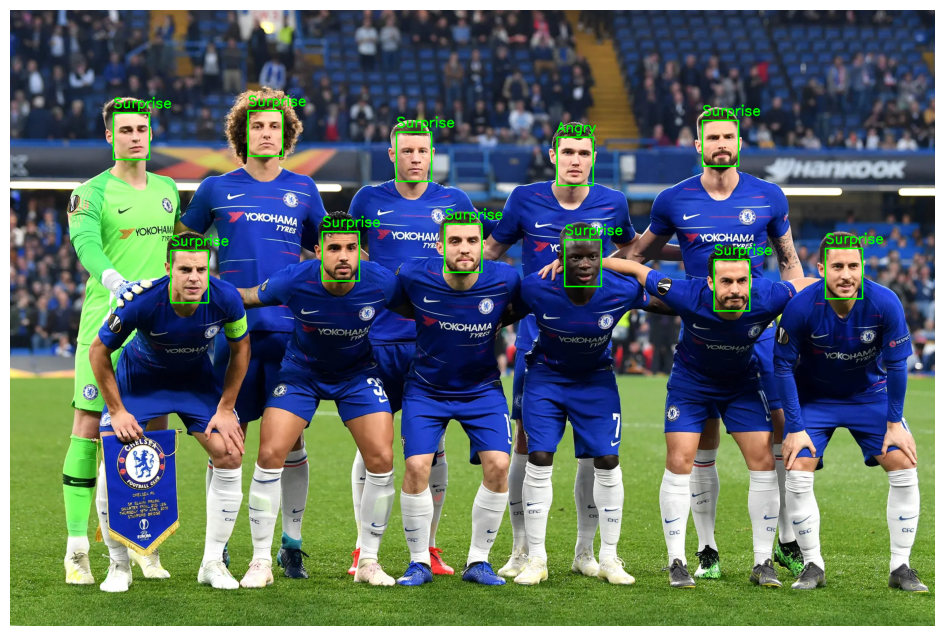

In [4]:
# Main execution
image_path = 'images/chelsea_1.jpg'  # Replace with your image path

# Detect faces
image, detected_faces = detect_faces(image_path)

if detected_faces:
    emotions = []
    for face in detected_faces:
        x, y, w, h = face['box']
        face_img = image[y:y+h, x:x+w]
        
        # Preprocess the face
        processed_face = preprocess_face(face_img, input_shape)
        
        # Predict emotion
        emotion, probabilities = predict_emotion(processed_face)
        emotions.append(emotion)
        
        print(f"Detected face at {face['box']}")
        print(f"Predicted emotion: {emotion}")
        print("Emotion probabilities:")
        for emotion_label, prob in zip(emotion_labels, probabilities):
            print(f"{emotion_label}: {prob:.2f}")
        print("\n")
    
    # Analyze lighting conditions
    lighting, brightness, contrast = analyze_lighting(image)
    print(f"Lighting condition: {lighting}")
    print(f"Average brightness: {brightness:.2f}")
    print(f"Contrast: {contrast:.2f}")
    print()
    
    # Analyze sentiment
    emotion_text = ' '.join(emotions)
    sentiment = sentiment_analyzer.polarity_scores(emotion_text)
    print(f"Sentiment Scores: {sentiment}")
    print()
    
    # Draw faces and emotions on the image
    image_with_faces = draw_faces_with_emotions(image, [face['box'] for face in detected_faces], emotions)
    
    # Display the image with detected faces and emotions
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image_with_faces, cv2.COLOR_BGR2RGB))
    # plt.title(f"Detected Faces with Emotions (Top Mood: {top_moods[0][0]})")
    plt.axis('off')
    plt.show()
else:
    print("No faces detected in the image.")